In [1]:
import arviz as az
import theano
import theano.tensor as tt
import pymc3 as pm


In [2]:
az.style.use("arviz-darkgrid")

In [3]:
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

plt.style.use("ggplot")
warnings.filterwarnings('ignore')


## 1. Dataset
The Eight Schools problem is a study of SAT coaching effects from eight schools [[1]](#References). For each the eight schools `num_schools` we have the estimated treatment effect (`treatment_effects`) and standard error of the effect estimate (`treatment_stddevs`).

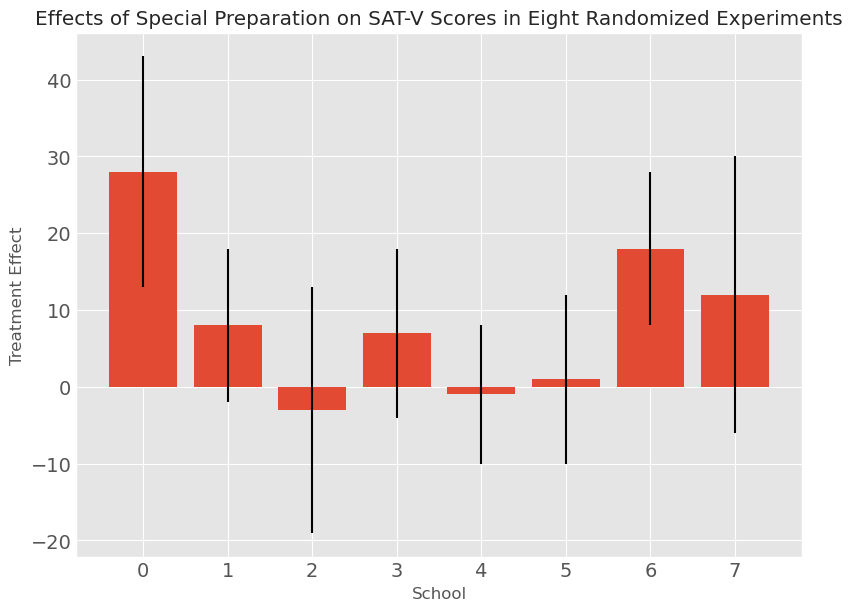

In [4]:
num_schools = 8  # number of schools
treatment_effects = np.array(
    [28, 8, -3, 7, -1, 1, 18, 12], dtype=np.float32)  # treatment effects
treatment_stddevs = np.array(
    [15, 10, 16, 11, 9, 11, 10, 18], dtype=np.float32)  # treatment SE

fig, ax = plt.subplots()
plt.bar(range(num_schools), treatment_effects, yerr=treatment_stddevs)
plt.title("Effects of Special Preparation on SAT-V Scores in Eight Randomized Experiments")
plt.xlabel("School")
plt.ylabel("Treatment Effect")
fig.set_size_inches(8, 6)
plt.show()


## 2. Data Modelling
From the data, we see that the effect widely varies across schools. As proposed in [[1]](#References) we start by defining a $\textit{hierarchical model}$. 
1. Each school’s `treatment_effect` is drawn from a normal distribution with unknown mean and variance. It is required to estimate these unknown parameters.
2. The observed effect in any school is sampled from a normal distribution with a mean and variance mentioned above.


### 2.1. Non-centered Parameterization
Let, ${\mathcal D}=\{x_{i}\}_{i=1}^{8}$ a set of observations, where each $x_i$ is a observed random variable (RV).
$$
x_i \sim \mathcal{N}\left(\theta_i, \sigma_i \right)
$$

Let $\mathbf{\Theta} = \left\{ \theta_i \right\}_{i=1}^8 $ used to calculate the probabilities of observed RVs. 

$$
\theta_i = \mu + \tau \eta_i
$$

where, $\eta_i \sim \mathcal{N}(0, 1)$ and $\mathbf{\eta} = \{ \eta \}_{i=1}^8 $. $\mathbf{\phi} = \left\{\mu, \tau \right\}$ parameterizing $\mathbf{\Theta}$. The parameters $\mu \sim \mathcal{N}(0, 10)$ and $\tau \sim \textit{HalfNormal}(1)$.

In [5]:
# Model definition
with pm.Model() as model:
    # prior
    eta = pm.Normal("eta", 0, 1, shape=num_schools)
    mu = pm.Normal("mu", 0, sigma=10)
    tau = pm.HalfNormal("tau", 10)
    
    theta = pm.Deterministic("theta", mu + tau * eta)

    # observation
    obs = pm.Normal("obs", theta, sigma=treatment_stddevs, observed=treatment_effects)


####  Model Diagram

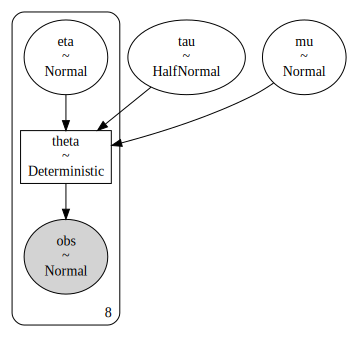

In [6]:
pm.model_to_graphviz(model)

### 3.1. Variational inference by MCMC

In [7]:
with model:
     # MC inference
    trace_h = pm.sample(1000, target_accept=0.95, return_inferencedata=True)
az.summary(trace_h, kind="stats")


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, mu, eta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


,mean,sd,hdi_3%,hdi_97%
eta[0],0.393,0.969,-1.478,2.149
eta[1],0.059,0.894,-1.600,1.750
eta[2],-0.122,0.953,-1.868,1.696
eta[3],-0.026,0.895,-1.716,1.623
eta[4],-0.247,0.950,-2.010,1.501
eta[5],-0.140,0.885,-1.804,1.545
eta[6],0.376,0.924,-1.315,2.134
eta[7],0.070,0.976,-1.845,1.802
mu,6.411,4.199,-1.582,14.040
tau,4.817,3.709,0.003,11.415


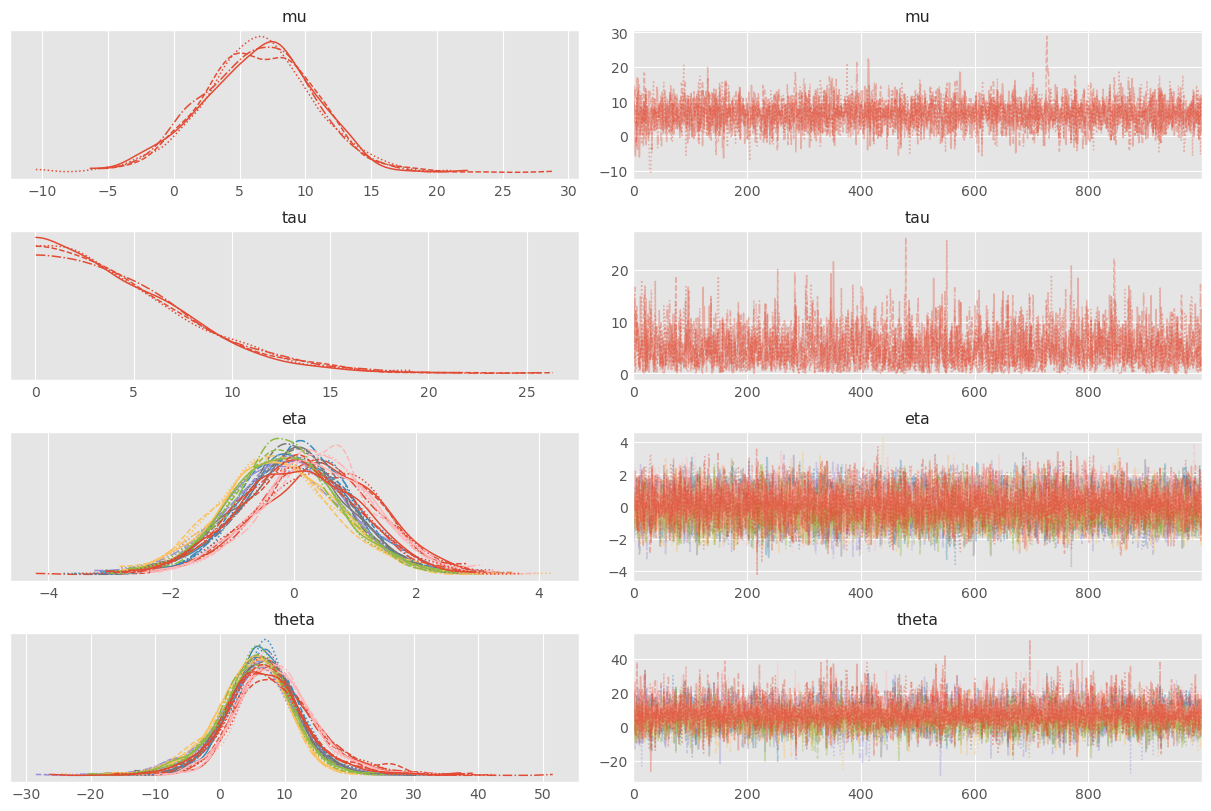

In [8]:
az.plot_trace(trace_h, var_names=["mu", "tau", "eta", "theta"]);

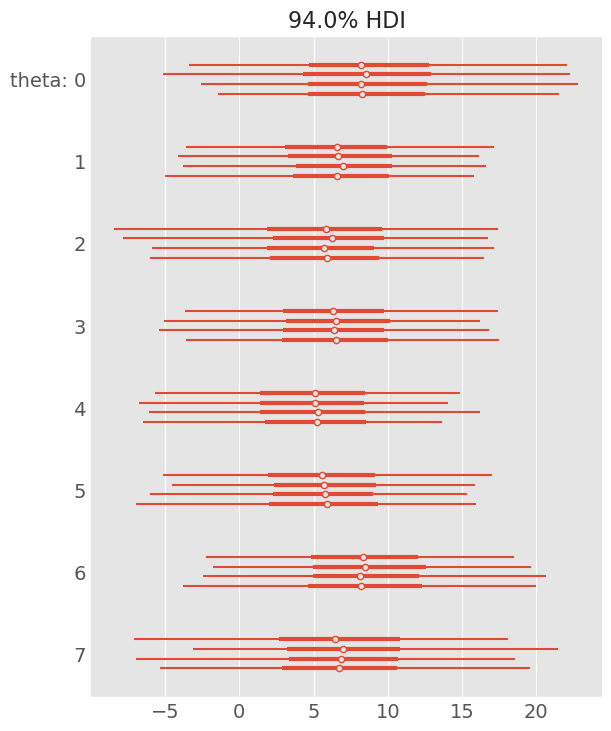

In [9]:
az.plot_forest(trace_h, var_names="theta");

### 3.2.  Operator Variational Inference (OPVI)
OPVI was developed in [[5]](#References) as a black box algorithm for performing variational inference. Implementational details are described in <a href="https://docs.pymc.io/api/inference.html">API</a>.
The $\textit{operator variational objective}$ framework as introduced in the paper consists of an $\textit{operator}(\mathcal{O}^{p,q})$ (a map from function to function) and $\textit{test functional family}(\mathcal{F})$ (that maps functions to real values), satisfying certain conditions and also a $\textit{distance function} (t(.))$ to ensure that the final objective is non-negative.
$$
\mathcal{L}(q;O^{p,q}, \mathcal{F}, t) = \underset{f \in \mathcal{F}}{sup} \hspace{0.5em} t(\mathbb{E}_{q(\textbf{z})}[(O^{p,q} f)({\mathbf{\Theta}})])
$$
In the first part of this section we will implement the KL-Divergence as an operator variation objective in `pymc3`. 

#### A. Operator based on Kullback Leibler Divergence
The operator that constructs Evidence Lower Bound (ELBO) objective is defined below,
$$
ELBO_\beta = \log p(\mathcal{D}|{\Theta}) - \beta KL(q \Vert p)
$$
For inference, we implement the Full-rank Gaussian approximation, where the posterior is approximated with a multivariate Gaussian distribution.

In [10]:
with model:
    ADVI_inference = pm.FullRankADVI(jitter=0.1)

ADVI_inference.fit(10000, obj_optimizer=pm.adam(learning_rate=0.01), obj_n_mc=10)

traceFL = ADVI_inference.approx.sample(5000)

Finished [100%]: Average Loss = 31.824


In [11]:
# # Vizualize posterior correlations
# dftrace = pm.trace_to_dataframe(inference.approx.sample(1000))
# sns.jointplot(dftrace.iloc[:, 10], dftrace.iloc[:, 11], kind="kde")

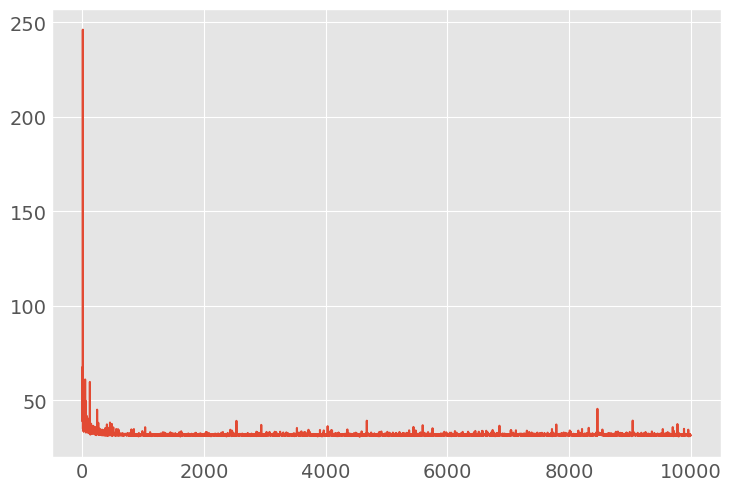

In [12]:
# plot the objective history
plt.plot(ADVI_inference.hist);

In [13]:
az.summary(traceFL, kind="stats")

,mean,sd,hdi_3%,hdi_97%
eta[0],0.272,0.962,-1.488,2.131
eta[1],-0.015,0.899,-1.728,1.662
eta[2],-0.106,0.933,-1.832,1.642
eta[3],0.105,0.942,-1.605,1.954
eta[4],-0.197,0.949,-2.009,1.551
eta[5],-0.127,0.927,-1.923,1.544
eta[6],0.313,0.877,-1.363,1.901
eta[7],0.059,1.005,-1.802,1.983
mu,6.506,4.066,-1.034,14.130
tau,4.034,2.957,0.563,8.958


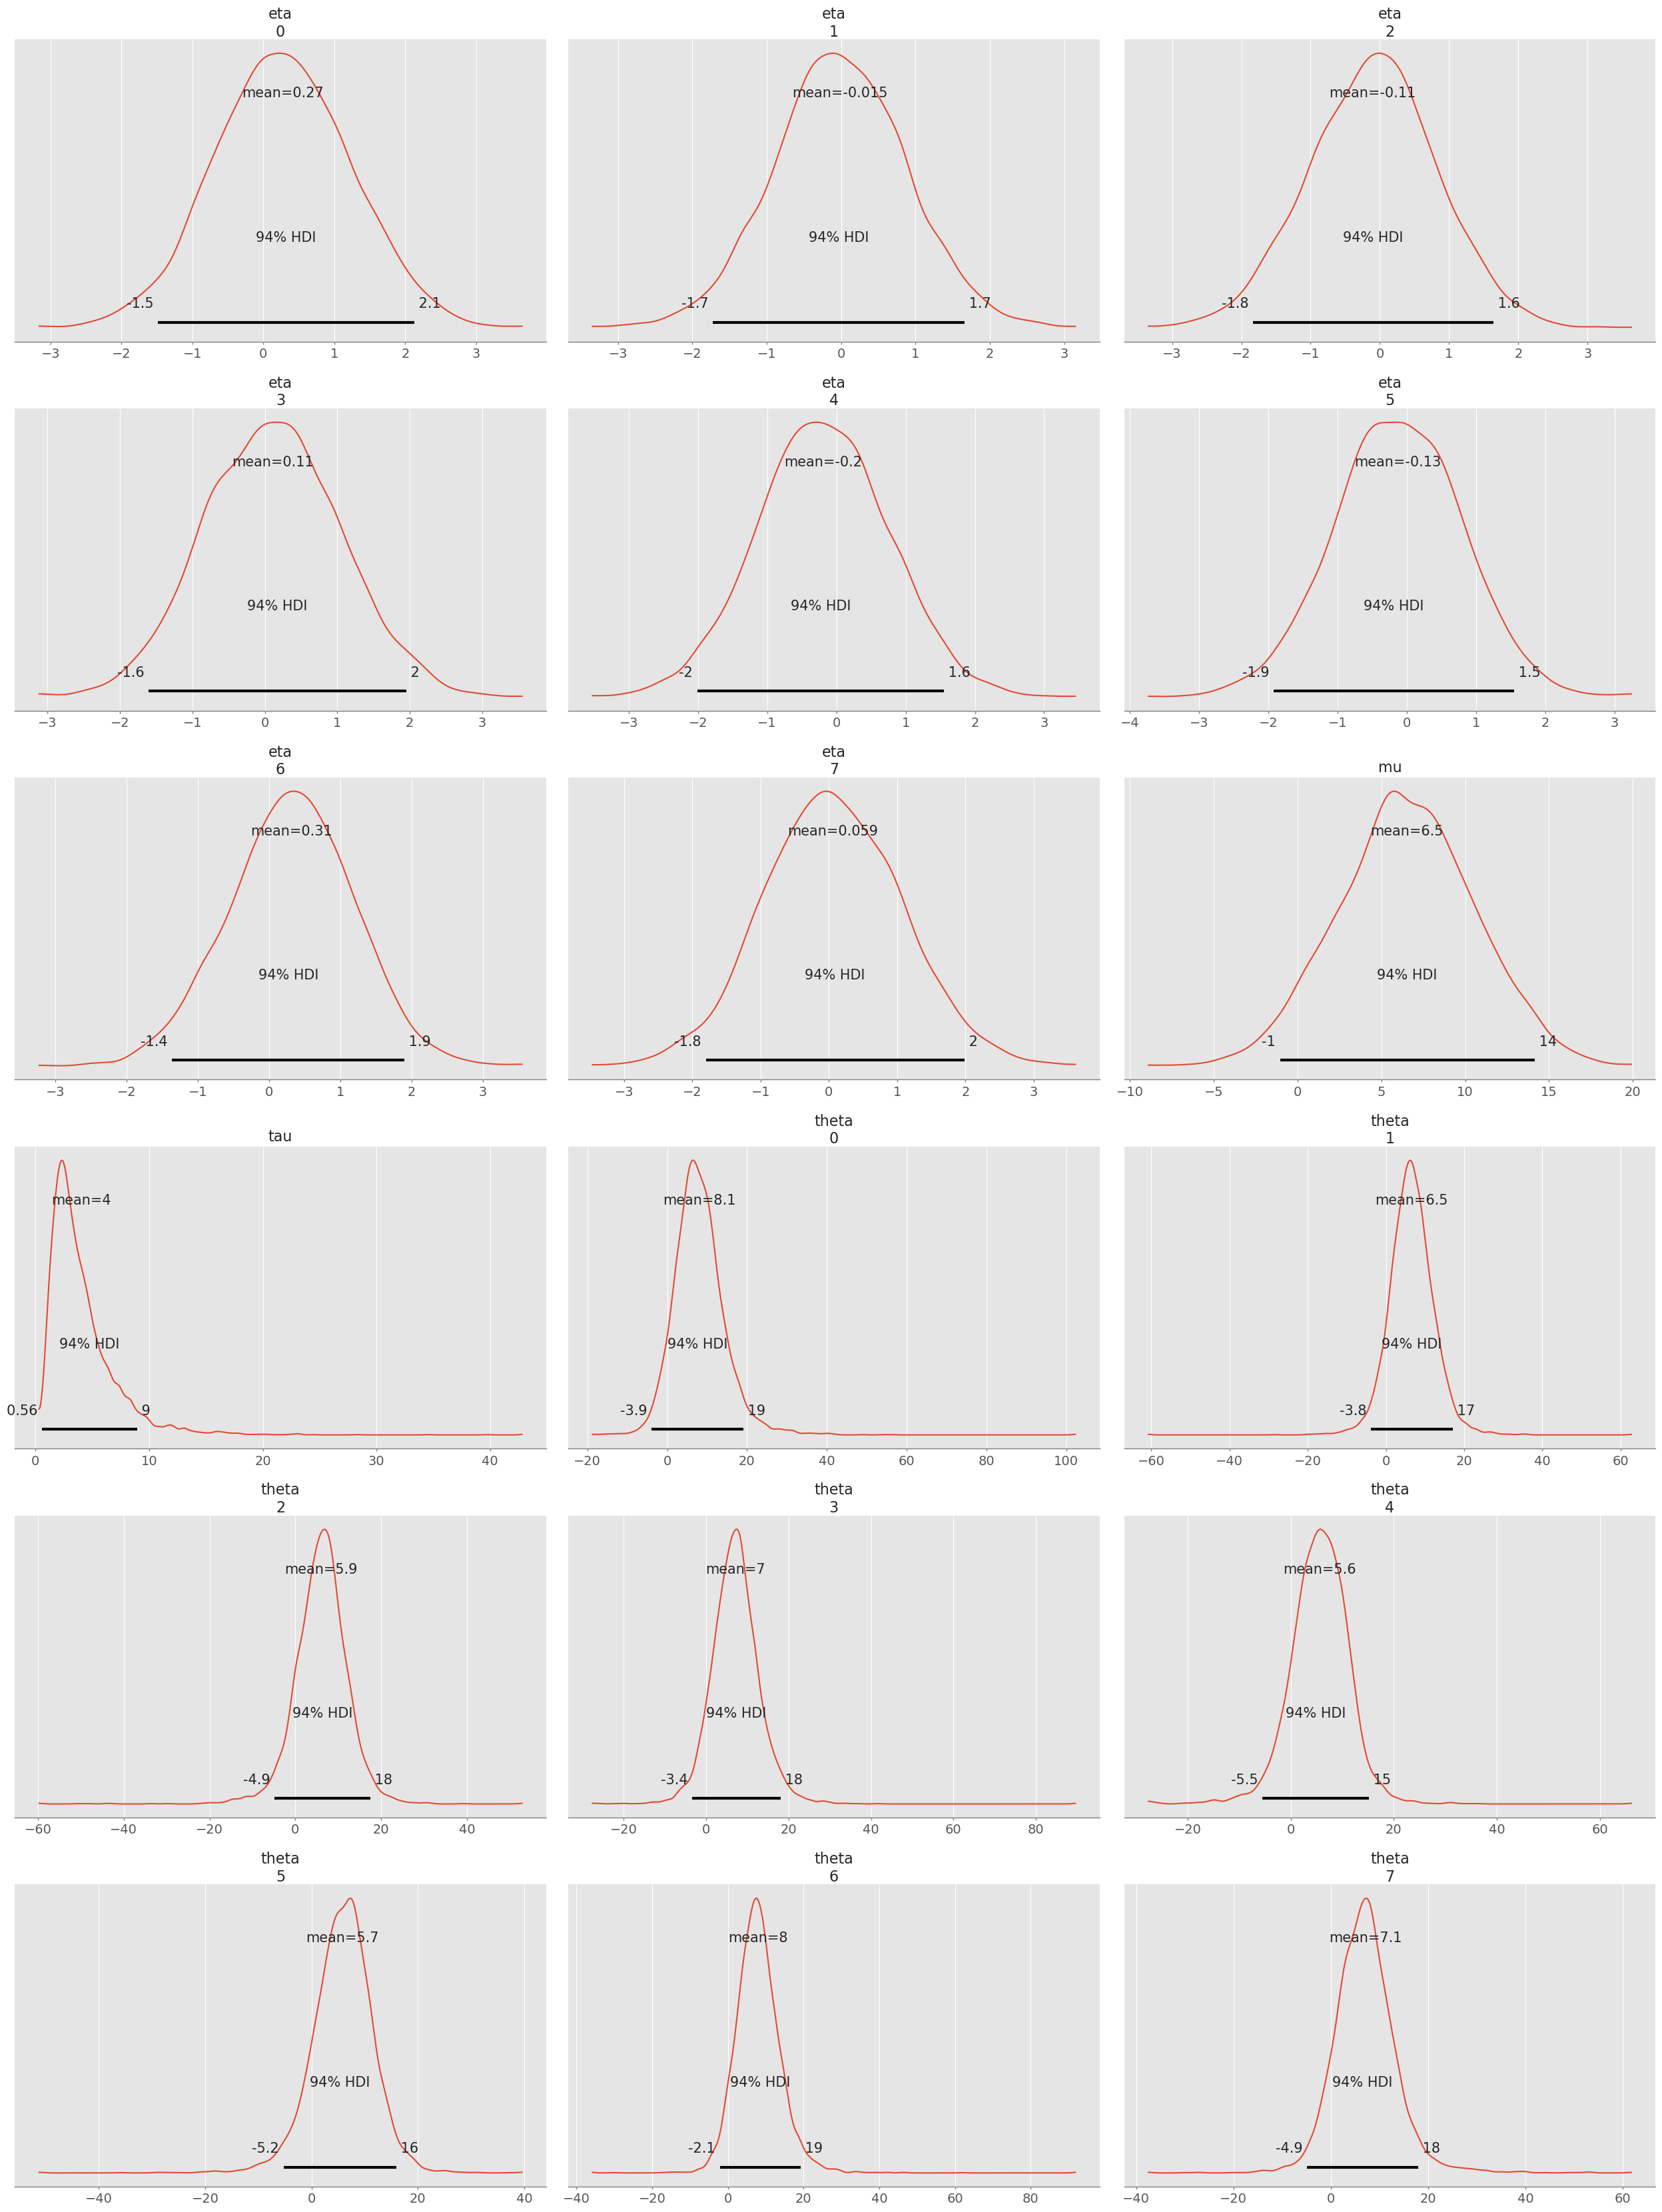

In [14]:
pm.plot_posterior(traceFL);

In the next we explore the $\chi$-divergence operator.

#### B. Operator based on $\chi$-divergence
The KL-divergence is a special case of a family of divergence functions known as $f$-divergence. 
$\textbf{Definition}$: Let ${\mathcal D}=\{x_{i}\}_{i=1}^{N}$ are $N$ observations.
The $f$-divergence between probability density functions, $q(\theta; \mathbf{\phi})$ and $p(\theta \vert \mathcal{D})$ is defined as [[3]](#References),
$$
D_f(q \parallel p) = \int_\theta f \left(\frac{q(\theta)}{p(\theta \vert \mathcal{D})}\right) p(\theta \vert \mathcal{D})d\theta = \mathbb{E}_p \left[f \left(\frac{q(\theta)}{p(\theta\vert \mathcal{D})}\right)\right]
$$
with $f(.)$ a convex function and $f(1)=0$. 

A common instance of the $f$-divergence is the $\chi$-divergence: $f(x) = x^2 - 1$.

For VI using $\chi$-divergence, it is proposed to minimize [[4]](#References), 
$$
D_{\chi^2}(p\parallel q) = \mathbb{E}_{q(\mathbf{\Theta};\mathbf{\phi})}\left[\left(\frac{p(\mathbf{\Theta}\vert \mathcal{D})}{q(\mathbf{\Theta};\mathbf{\phi})}\right)^2 - 1 \right]
$$

VI by minimization of the KL-divergence provides the lower bound (ELBO) on the model evidence $log(p(\mathcal{D}))$. Here, the goal is to minimize $D_{\chi^2}$, such that,
$$
\mathbf{\phi}* = \underset{\mathbf{\phi} \in \mathbf{\Phi}}{\text{argmin}} D_{\chi^2}(p\parallel q)
$$

Minimizing the $\chi$-divergence is equivalent to maximization of the $\chi$-Upper Bound (CUBO)[[4]](#References). Similar to ELBO, a bound on the model evidence is derived.


Consider,
$$
\mathbb{E}_{q(\mathbf{\Theta};\mathbf{\phi})}\left[\left(\frac{p(\mathcal{D}, \mathbf{\Theta})}{q(\mathbf{\Theta};\mathbf{\phi})}\right)^2 \right] = 1 + D_{\chi^2}(p(\mathcal{D}, \mathbf{\Theta}) \parallel q(\mathbf{\Theta};\mathbf{\phi}))
$$
Then,
$$
\mathbb{E}_{q(\mathbf{\Theta};\mathbf{\phi})}\left[\left(\frac{p(\mathbf{\Theta} \vert \mathcal{D})}{q(\mathbf{\Theta};\mathbf{\phi})}\right)^2 \right] = \mathbb{E}_{q(\mathbf{\Theta};\mathbf{\phi})}\left[\left(\frac{p(\mathbf{\Theta}, \mathcal{D}) p(\mathcal{D})}{q(\mathbf{\Theta};\mathbf{\phi})}\right)^2 \right]  \\
 = p^2(\mathcal{D}) \mathbb{E}_{q(\mathbf{\Theta};\mathbf{\phi})}\left[\left(\frac{p(\mathcal{D}, \mathbf{\Theta})}{q(\mathbf{\Theta};\mathbf{\phi})}\right)^2 \right] \\
 = p^2(\mathcal{D})(1 + D_{\chi^2}(p(\mathcal{D}, \mathbf{\Theta}) \parallel q(\mathbf{\Theta};\mathbf{\phi}))
$$

Taking logarithm on both sides the model evidence term is seperated,

$$
\frac{1}{2}\text{log} \left(\mathbb{E}_{q(\mathbf{\Theta};\mathbf{\phi})}\left[\left(\frac{p(\mathbf{\Theta} \vert \mathcal{D})}{q(\mathbf{\Theta};\mathbf{\phi})}\right)^2 \right]\right) = -\text{log}(p(\mathcal{D})) + \frac{1}{2}\text{log}\left(\mathbb{E}_{q(\mathbf{\Theta};\mathbf{\phi})}\left[\left(\frac{p(\mathcal{D},\mathbf{\Theta})}{q(\mathbf{\Theta};\mathbf{\phi})}\right)^2 \right]\right)
$$

The LHS of the equation is the logarithm of the $\chi^2$-divergence, minimizing of which is equivalent to minimizing the objective CUBO,
$$
\mathcal{L}_{\chi^2} = \frac{1}{2}\text{log}\left(\mathbb{E}_{q(\mathbf{\Theta};\mathbf{\phi})}\left[\left(\frac{p(\mathcal{D},\mathbf{\Theta})}{q(\mathbf{\Theta};\mathbf{\phi})}\right)^2 \right]\right)
$$


### Optimization of the CUBO

The score of the objective function, 
$$
\mathbf{L} = exp \left\{2 \text{CUBO}_2 (\mathbf{\phi})\right\} 
$$

In [15]:
# Define the CHIVI operator
from pymc3.variational.opvi import Operator

class CHI(Operator):
    def __init__(self, approx):
        Operator.__init__(self, approx)
        self._logP_prior =  approx.sized_symbolic_varlogp
        self._logP_LL =  approx.sized_symbolic_datalogp
        self._logQ = approx.symbolic_logq
        
    def apply(self, f):
        logP = self._logP_prior + self._logP_LL
        c = (2 * logP - 2 * self._logQ).max()
        
        return ((2 * logP - 2 * self._logQ) - c).exp().mean()


In [16]:
from pymc3.variational.inference import Inference

class CHIpq(Inference):
    r"""**Chi-Square Divergence Inference**
    General approach to fit Approximations that define :math:`logq`
    by minimizing CUBO (Chi Upper Bound).
    .. math::
        L = exp \{2 \text{CUBO}_2 (\mathbf{\phi})\} = \sum_i \frac{p(x_i, \theta_i)^2}{q(\theta_i; \mathbf{\phi})}
    Parameters
    ----------
    approx: :class:`Approximation`
        Approximation to fit, it is required to have `logQ`
    References
    ----------
    -   Dieng, A. B., Tran, D., Ranganath, R., Paisley, J., & Blei,
        D. M. (2016). Variational Inference via 𝜒-Upper Bound 
        Minimization. arXiv preprint arXiv:1611.00328.
    """

    def __init__(self, approx):
        super().__init__(CHI, approx, None)

In [17]:
from pymc3.variational.opvi import Approximation, Group
from pymc3.variational.inference import Inference
    
with model:
    group1 = Group([mu, tau, eta], vfam='scale-loc')
    group2 = Group(None, vfam='scale-loc')
    
    Approx = Approximation([group1, group2])
    CHI_operator = CHI(Approx)
    CHI_inference = CHIpq(Approx)
    
CHI_inference.fit(10000, obj_optimizer=pm.adam(learning_rate=0.001), obj_n_mc=10)
       

Finished [100%]: Average Loss = 0.1206


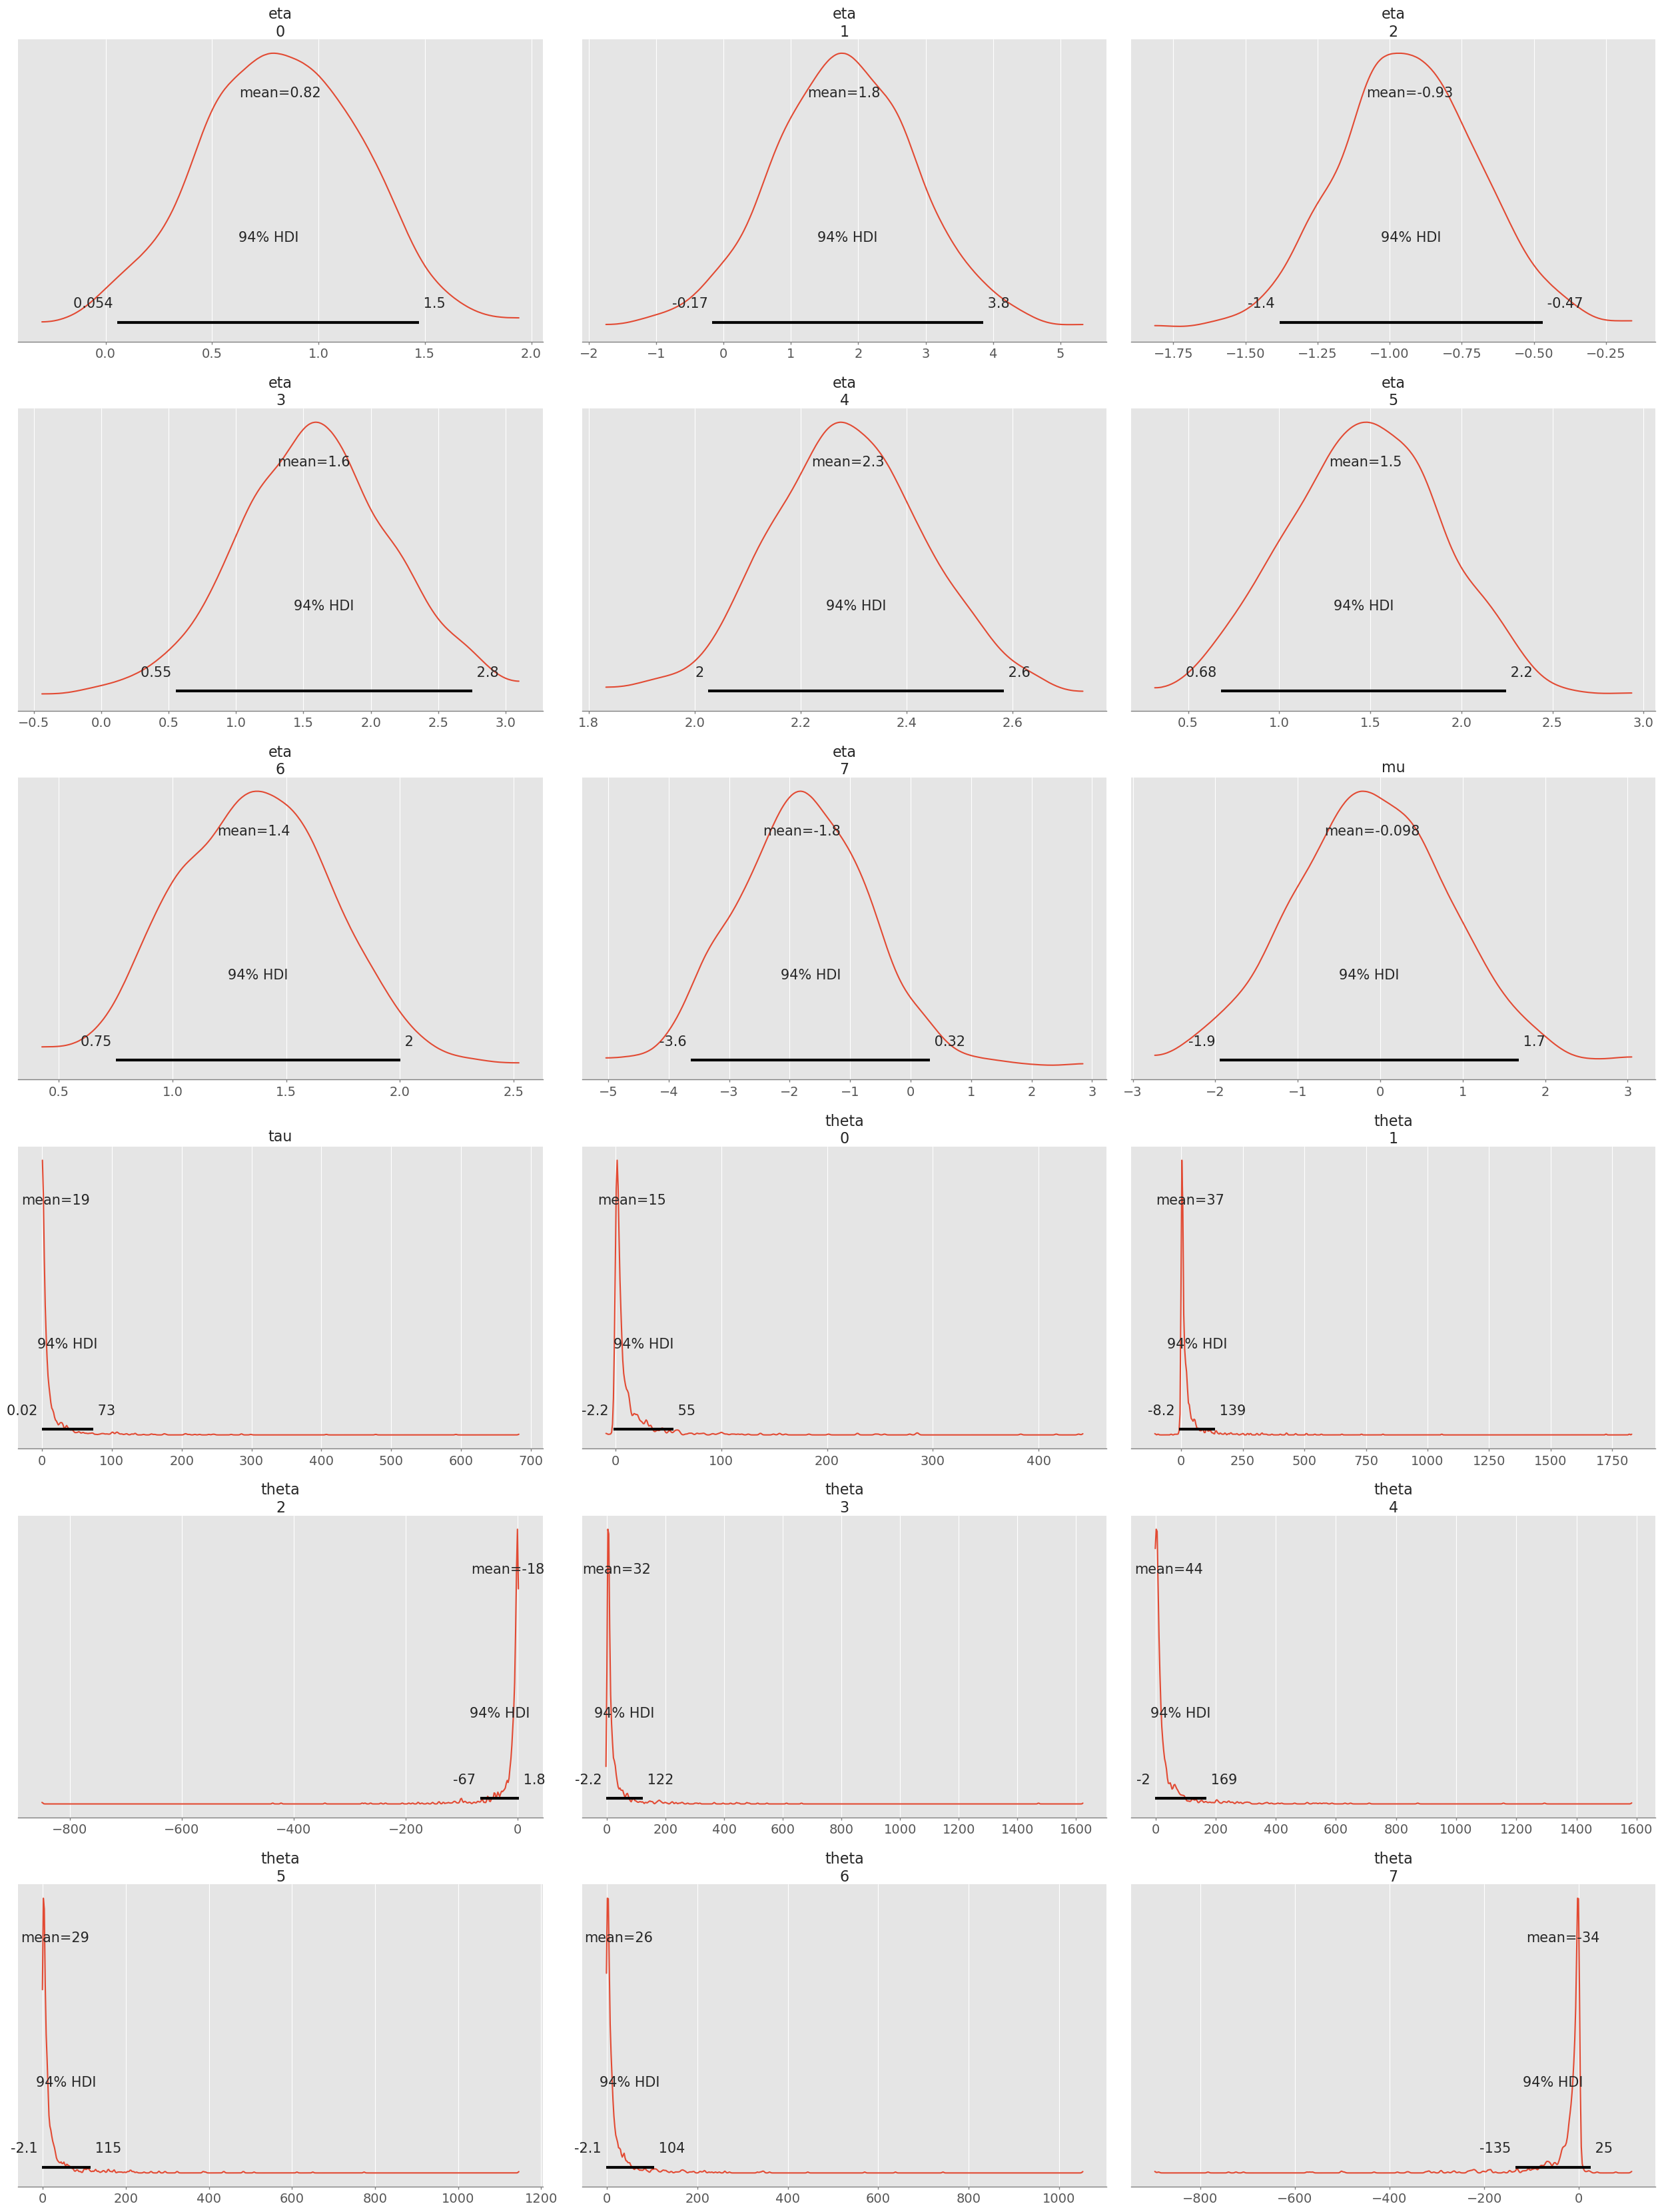

In [18]:
pm.plot_posterior(Approx.sample(1000));

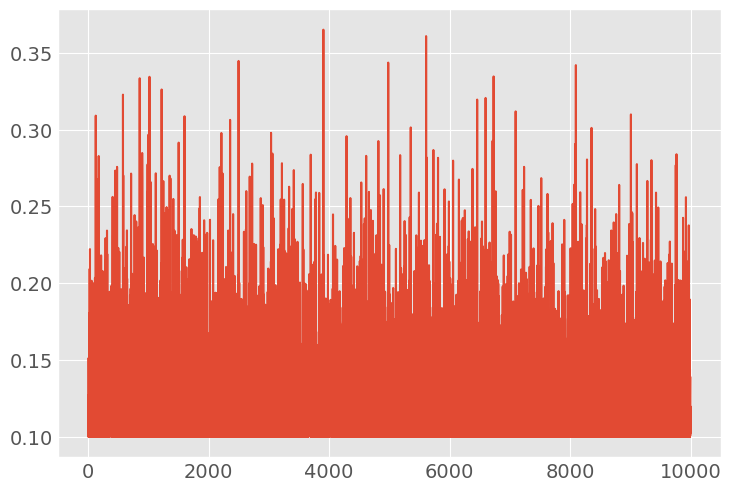

In [19]:
# plot the objective history
plt.plot(CHI_inference.hist);

In [20]:
means = approx.bij.rmap(approx.mean.eval())
sds = approx.bij.rmap(approx.std.eval())

from scipy import stats

varnames = means.keys()
fig, axs = plt.subplots(nrows=len(varnames), figsize=(12, 18))
for var, ax in zip(varnames, axs):
    mu_arr = means[var]
    sigma_arr = sds[var]
    ax.set_title(var)
    for i, (mu, sigma) in enumerate(zip(mu_arr.flatten(), sigma_arr.flatten())):
        sd3 = (-4 * sigma + mu, 4 * sigma + mu)
        x = np.linspace(sd3[0], sd3[1], 300)
        y = stats.norm(mu, sigma).pdf(x)
        ax.plot(x, y)
        if hierarchical_trace[var].ndim > 1:
            t = hierarchical_trace[var][i]
        else:
            t = hierarchical_trace[var]
        sns.distplot(t, kde=False, norm_hist=True, ax=ax)
fig.tight_layout()



NameError: name 'approx' is not defined

## References

<a id="References"></a>


<ol>
<li> Rubin, D. (1981). Estimation in Parallel Randomized Experiments. Journal of Educational Statistics, 6(4), 377-401. doi:10.2307/1164617 </li>
<li> Gelman, A., Carlin, J. B., Stern, H. S., Dunson, D. B., Vehtari, A., & Rubin, D. B. (2013). Bayesian data analysis. CRC press.</li>
<li> Wan, N., Li, D., & Hovakimyan, N. (2020). f-Divergence Variational Inference. Advances in Neural Information Processing Systems, 33.</li>
<li> Dieng, A. B., Tran, D., Ranganath, R., Paisley, J., & Blei, D. M. (2016). Variational Inference via $\chi $-Upper Bound Minimization. arXiv preprint arXiv:1611.00328.</li>
<li> Ranganath, R., Altosaar, J., Tran, D., & Blei, D. M. (2016). Operator variational inference. arXiv preprint arXiv:1610.09033.</li>
</ol>
